In [1]:
import sys
import time
import bibtexparser
import itertools
import requests
import re
import matplotlib as plt
import pandas as pd
from bs4 import BeautifulSoup
from tabulate import tabulate

In [2]:
import bibtexparser
bibtex_file = open('gap-publishednicer.bib.txt', encoding='utf-8')
bib_data = bibtexparser.load(bibtex_file)

In [3]:
bib = bib_data.entries

### Here are the 3 datasets we will start with.

In [4]:
bib_df = pd.DataFrame.from_dict(bib) # large one from the Bibliography
review_df = pd.read_csv('no_citation_text.csv', dtype='str') # MR numbers who came back with no `GAP` text found inside
corpus_df = pd.read_csv('gap_citations_corpus.csv', dtype='str') # CItations scraped from MathSciNet website

# Larger dataset from Bibliography

* how to deal with NaN missing values ? *

We only need some of these columns, hence we `drop` the rest.

In [5]:
bib_df.columns

Index(['printedkey', 'doi', 'url', 'mrreviewer', 'mrnumber', 'mrclass', 'issn',
       'fjournal', 'pages', 'year', 'volume', 'journal', 'title', 'author',
       'ENTRYTYPE', 'ID', 'number', 'school', 'booktitle', 'isbn', 'note',
       'publisher', 'day', 'keywords', 'month', 'series', 'annote', 'type',
       'address', 'institution', 'howpublished', 'editor', 'bookeditor',
       'edition', 'key', 'organization'],
      dtype='object')

In [6]:
bib_df.drop(bib_df.columns[[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]], axis = 1, inplace = True)

In [7]:
bib_df.columns

Index(['mrnumber', 'year', 'journal', 'author', 'ENTRYTYPE'], dtype='object')

We reorder the columns.

In [8]:
bib_df = bib_df[['mrnumber', 'author', 'journal', 'year', 'ENTRYTYPE']]

Then we change the `mrnumber` coulmn name to `MRN` so we cane later merge this dataframe with the other one.

In [9]:
bib_df.columns = ['MRN', 'author', 'journal', 'year', 'ENTRYTYPE']

In [10]:
bib_df

,MRN,author,journal,year,ENTRYTYPE
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article
2,NaN,"Abdeljaouad, I.",RAIRO-INF THEOR APPL,1999,article
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article
...,...,...,...,...,...
3362,2647300,"Zusmanovich, P.",J. Geom. Phys.,2010,article
3363,2735394,"Zusmanovich, P.",J. Algebra,2010,article
3364,3201064,"Zusmanovich, P.",J. Algebra,2014,article
3365,3598575,"Zusmanovich, P.",Linear Algebra Appl.,2017,article


Data types and count of non-null values for each columns.

In [11]:
bib_df.info(show_counts  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MRN        3159 non-null   object
 1   author     3367 non-null   object
 2   journal    3047 non-null   object
 3   year       3367 non-null   object
 4   ENTRYTYPE  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


Looking at the `MRN` columns, some cells are empty - `NaN`

In [12]:
bib_df.iloc[3274]

MRN                    NaN
author          Wegner, A.
journal                NaN
year                  1989
ENTRYTYPE    mastersthesis
Name: 3274, dtype: object

In [13]:
bib_df.describe()

,MRN,author,journal,year,ENTRYTYPE
count,3159,3367,3047,3367,3367
unique,3158,2511,384,43,10
top,3656296,"Eick, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


### We will look at the `year` column. There are several anomalies and we need just 4 digits in each cell.

In [14]:
bib_df.sort_values('year', ascending=False)

,MRN,author,journal,year,ENTRYTYPE
3165,3973299,"Then, H.",NaN,[2019] \copyright 2019,incollection
1546,3898507,"Greer, M.",NaN,[2019] \copyright 2019,incollection
3133,3898514,"Stuhl, I. and Vojtěchovský, P.",NaN,[2019] \copyright 2019,incollection
3147,3782458,"Swinarski, D.",NaN,[2018] \copyright 2018,incollection
1981,4167659,"Kaushik, R. and Yadav, M. K.",J. Algebra,2021,article
...,...,...,...,...,...
3274,NaN,"Wegner, A.",NaN,1989,mastersthesis
2689,NaN,"Niemeyer, A.",NaN,1988,mastersthesis
2673,NaN,"Nickel, W.",NaN,1988,mastersthesis
3018,NaN,"Schönert, M.",NaN,1987,mastersthesis


We will use `.str` and a regular expresion `(r'^(\d{4})'` which first converts all year cells to strings then takes the first 4 digits from each. We then replace the old values with the filtered ones.

In [15]:
bib_df['year'] = bib_df['year'].str.extract(r'^(\d{4})', expand=False)

In [16]:
bib_df['year'].value_counts()

2017    188
2013    175
2018    168
2020    166
2019    165
2010    163
2015    162
2016    158
2014    154
2011    152
2007    142
2012    142
2008    132
2004    131
2005    128
2009    124
2006    118
2001    107
2003    101
1999     84
2002     84
2000     78
1997     76
1998     58
1995     56
2021     39
1996     34
1994     28
1993     25
1992     13
1991      5
1989      2
1987      2
1988      2
1990      1
Name: year, dtype: int64

We inspect the result and no more anomalies are visible. Data type is integer which is also fine.

In [17]:
bib_df['year'].describe()

count     3363
unique      35
top       2017
freq       188
Name: year, dtype: object

Barchart dislaying number of GAP citations per year.

* GAP citation counts for each year, sorted chronologically.

In [18]:
year_chrono = bib_df['year'].value_counts()
chrono_df = year_chrono.to_frame()
chrono = chrono_df.sort_index()

<AxesSubplot:title={'center':'Annual GAP citations data'}, xlabel='Years', ylabel='Count'>

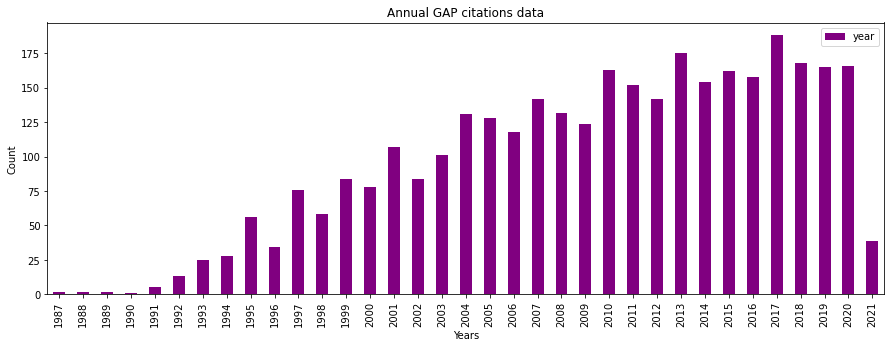

In [38]:
chrono.plot(kind="bar", figsize=(15, 5), title='Annual GAP citations data', xlabel='Years', 
                ylabel='Count', color='purple')

Top 20 journals citing GAP.

In [39]:
top_journals = bib_df['journal'].value_counts()
top_20 = pd.DataFrame(top_journals.head(20))
top_20.reset_index()

,index,journal
0,J. Algebra,387
1,Comm. Algebra,207
2,J. Symbolic Comput.,104
3,Discrete Math.,88
4,J. Algebra Appl.,85
5,J. Group Theory,67
6,Internat. J. Algebra Comput.,64
7,J. Pure Appl. Algebra,64
8,Des. Codes Cryptogr.,59
9,LMS J. Comput. Math.,47


Only for alternative, useful for copy/paste plain text - quick to load.
Try to allign on the left - journals.

In [22]:
headers = ['Journal name', 'GAP Citations count']
print(tabulate(top_20, headers = headers, tablefmt = 'pretty'))

+------------------------------+---------------------+
|         Journal name         | GAP Citations count |
+------------------------------+---------------------+
|          J. Algebra          |         387         |
|        Comm. Algebra         |         207         |
|     J. Symbolic Comput.      |         104         |
|        Discrete Math.        |         88          |
|       J. Algebra Appl.       |         85          |
|       J. Group Theory        |         67          |
| Internat. J. Algebra Comput. |         64          |
|    J. Pure Appl. Algebra     |         64          |
|     Des. Codes Cryptogr.     |         59          |
|     LMS J. Comput. Math.     |         47          |
|     Arch. Math. (Basel)      |         44          |
|      Experiment. Math.       |         42          |
|     European J. Combin.      |         42          |
|         Math. Comp.          |         37          |
|       Algebra Colloq.        |         35          |
|     Elec

In [28]:
bib_df['ENTRYTYPE'].describe()

count        3367
unique         10
top       article
freq         2976
Name: ENTRYTYPE, dtype: object

In [24]:
bib_df['ENTRYTYPE'].value_counts()

article          2976
incollection      204
inproceedings      54
phdthesis          47
mastersthesis      46
book               31
misc                5
techreport          2
manual              1
inbook              1
Name: ENTRYTYPE, dtype: int64

##### The most frequent type of work citing GAP: we can see that GAP is predominantly cited in articles - 2976 times.

In [25]:
types_pub = pd.DataFrame(bib_df['ENTRYTYPE'].value_counts())
types_pub.columns = ['GAP Citations Count']
types_pub.index.names = ['Publication Type']
types_pub

,GAP Citations Count
Publication Type,
article,2976
incollection,204
inproceedings,54
phdthesis,47
mastersthesis,46
book,31
misc,5
techreport,2
manual,1


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

interact(f, x=['apples','oranges']);

### Top 20 authors citing GAP in their work

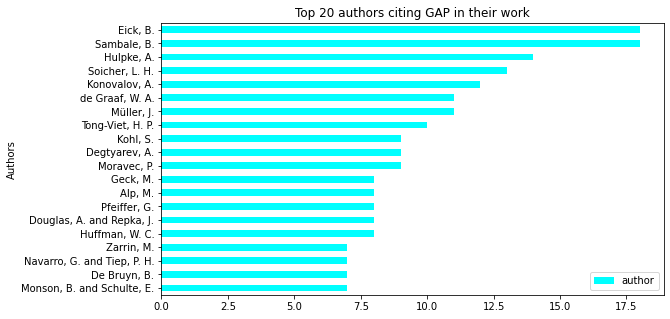

In [40]:
authors = bib_df['author'].value_counts()
top = authors.head(20)
top = top.sort_values(ascending=True)
top = top.to_frame()
chart = top.plot(kind="barh",
                 figsize=(9,5), title='Top 20 authors citing GAP in their work', 
                 xlabel='Authors', 
                 ylabel='Count', color='cyan')


#  Corpus and Review

What are the GAP Citation practices ???
The longer the citation is the more details it contains - measure lenght ?

To do
+ check Citations strings lenghts to isolate too short ones

+ website
+ remaining HTML characters

Two citations containing Singapore instead of GAP present.



In [41]:
corpus_df

,MR,Citation
0,MR4056124,"GAP – Groups, algorithms, programming - a syst..."
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:..."
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro..."
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ..."
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg..."
...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais..."
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi..."
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h..."
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g..."


In [42]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

def get_citation(mrno):
    r = corpus_df[corpus_df['MR'] == mrno]
    return r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']
# r = corpus_df[corpus_df['MR'] == mrno]
# return [r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']]

In [44]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
unknown_ver = []
def get_version(s):
    match = re.search("(?:(\d+\.(?:\d+\.)*\d+))", s, re.IGNORECASE)
    if match != None:
        return match.group(1)
    else:
        print('No match:', s)
        unknown_ver.append(s)

In [45]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
def is_package(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("package", citation, re.IGNORECASE) != None:
        print('***Package***:', mrno, citation)
        return 'Package'
# this way we catch cases where GRAPE is used without the word package
    elif re.search("grape", citation, re.IGNORECASE) != None: 
        print('??? GRAPE PKG ???:', mrno, citation)
        return 'GRAPE GAP Package'
    else:
        print('***Not a Package***:', mrno, citation)
        return series['Version']

First we create the version column.

In [46]:
corpus_df.insert(loc=2, column='Version', value=' ')

In [47]:
corpus_df['Version'] = corpus_df['Citation'].map(get_version)

No match: GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
No match: Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
No match: M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [10].
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [8].
No match: Gamble, G., Nickel, W., O'Brien, E.A.: ANU p-Quotient–p-Quotient and p-Group Generation Algorithms (2006). An accepted GAP 4 package, available also in MAGMA
No match: M. Schönert et al, GAP: groups, algorithm and programming, © 1992 by Lehrstuhl D für Mathematik, distributed with the GAP software via ftp from samson.math.rwth-aachen.de.
No match: M. Delgado, P. A. G

No match: W. Nickel, NQ-nilpotent quotients of finitely presented groups (A refereed GAP 4 package) (1998). http://www.gap-system.org/Packages/nq.html
No match: Greg Gamble, Alexander Hulpke, George Havas, and Colin Ramsay. "GAP Package ACE; Advanced Coset Enumerator." Available online (http://www.gap-system.org/Packages/ace.html), 2004.
No match: The GAP Group. "Balanced Presentations for Covering Groups of Simple Groups." Available online (http://www.gap-system.org/Doc/Examples/balanced.html), 2004.
No match: Gamble, G., Havas, G., Hulpke, A. (2000a). PGRelFind: a GAP example using the share package ACE. http://www-gap.dcs.st-and.ac.uk/$\sim$gap/Intro/pgrelfind.html.
No match: Gamble, G., Havas, G., Hulpke, A., Ramsay, C. (2000b). ACE: a GAP 4 interface to the Advanced Coset Enumerator of $G$, Havas and C. Ramsay, http://www-gap.dcs.st-and.ac.uk/$\sim$gap/Share/ace.html.
No match: Greg Gamble, Alexander Hulpke, George Havas and Colin Ramsay, GAP package ACE; Advanced Coset Enumerator

No match: A. S. Detinko, D. L. Flannery, and A. Hulpke, GAP Functionality for Zariski Dense Groups, Oberwolfach Preprints OWP 2017-22.
No match: The GAP Group, GAP – Groups, Algorithms, and Programming, http://www.gapsystem.org
No match: M. Neunhöffer, Á. Seress, et al., "The GAP Package recog." A Collection of Group Recognition Methods, http://gap-packages.github.io/recog/
No match: H. Dietrich, P. Faccin, and W. A. de Graaf, "CoReLG - computing with real Lie groups", a GAP 4 package, 2012, Available at http://www.science.unitn.it/$\sim$corelg.
No match: M. Costantini and W. A. de Graaf, "Singular: a GAP 4 package", The GAP Group, 2006, Available at http://www.gap-system.org/Packages/singular.html.
No match: W. A. de Graaf, "SLA: computing with simple Lie algebras, a GAP 4 package", 2012, Available at http://www.science.unitn.it/$\sim$degraaf/sla.html.
No match: Heiko Dietrich, Paolo Faccin, Willem A. de Graaf, Corelg: computing with real Lie groups, A GAP 4 package, available at scie

No match: Computer program GAP, available from http://www-gap.dcs.st-andrews.ac.uk/$\sim$gap/
No match: S. P. Glasby, Supporting $\ssf{GAP}$ and Magma code, http://www.maths.uwa.edu.au/~glasby/RESEARCH.
No match: M. SCHO NERT et al., `GAP: groups, algorithms, and programming', RWTH Aachen, 1992.
No match: M. Schönert et al., "GAP: Groups, Algorithms, and Programming," RWTH, Aachen, 1992.
No match: The GAP Group, Gap – groups, algorithms, and programming, http://www.gap-system.org.
No match: M. Geck, G. Hiss, F. Lübeck, G. Malle, J. Michel & G. Pfeiffer - "Chevie: computer algebra package for GAP3.", http://people.math.jussieu.fr/{$\sim${}}jmichel/chevie/chevie.html.
No match: GAP, Groups algebras and permutations, http://www-groups.dcs.st-and.ac.uk/$\sim$gap.
No match: Goodwin, S.–The GAP4 function DenseTest, (2003), (http://www.mat.bham.ac.uk/S.M.Goodwin/densetest.html).
No match: Eick, B., Nickel, W. (2000). Polycyclic, A GAP package, see The Gap Team (1997).
No match: The Gap Team (

No match: K. Magaard, S. Shpectorov and H. Völklein, A GAP package for braid orbit computation, and applications, Experiment. Math. 12 (2003), no. 4, 385–393. MR2043989 (2005e:12007) 
MR2043989
No match: B. Eick and W. Nickel, Polycyclic – Computing with polycyclic groups, 2002. A GAP Package, see [19]. 
MR1829476
No match: The GAP Group, GAP - Groups, Algorithms and Programming, Version 4–4 (2005), available at http://www.gap-system.org.
No match: W. Nickel, $nq$ – Nilpotent Quotients of Finitely Presented Groups, 2003. A GAP Package, see [19].
No match: The GAP group, GAP—Groups, algorithms and programming, http://www-gap.dcs.st-and.ac.uk/$\sim$gap, 2006.
No match: GAP, Groups, algorithms and programming, 2000. http://www-gap.idcs.st-and.ac.uk/$\sim$gap.
No match: GAP, Groups, algorithms and programming, http://www.gap-system.org.
No match: M. Vaughan-Lee and B. Eick, LiePRing—A GAP Package for computing with nilpotent Lie rings of prime-power order (2014). http://www.gap-system.org/

No match: A. M. Cohen and J. W. Knopper, "GAP package GBNP: computing Gröbner bases of noncommutative polynomials", software package, 2016, available at http://www.gap-system.org/Packages/gbnp.html.
No match: Schönert, M. et al., 1995. GAP—Groups, Algorithms, and Programming, fifth ed. Lehrstuhl D für Mathematik. Rheinisch Westfä lische Technische Hochschule, Aachen, Germany.
No match: The GAP Group, 1997. Lehrstuhl D für Mathematik, RWTH Aachen, Germany and School of Mathematical and Computational Sciences, U. St. Andrews, Scotland. GAP—Groups, Algorithms, and Programming, Version 4.
No match: The GAP Group (2008) GAP—Groups, Algorithms, and Programming. http://www.gap-system.org
No match: M. Schönert, et al., "GAP—Groups, Algorithms, and Programming," 4th ed., 1994.
No match: G. Ellis, GAP package HAP, 2008, http://hamilton.nuigalway.ie/Hap/www/index.html.
No match: D. F. Holt, B. Eick and E. O'Brien, GAP package cohomolo, 2008, http://www.warwick.ac.uk/staff/D.F.Holt/cohomolo/.
No m

In [48]:
corpus_df['Version'].value_counts()

4.4       460
4.4.12    310
4.3       232
4.4.10    136
4.2       127
         ... 
3.0.20      1
0.2.1       1
2.8         1
2.1.3       1
1.25        1
Name: Version, Length: 196, dtype: int64

Then we apply the function which chekcs if it is a case of citing GAP Package. Packages are connected to GAP, but technically is a separate piece of software.

In [49]:
corpus_df['Version'] = corpus_df.apply(is_package,axis=1)

***Not a Package***: MR4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Package***: MR3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Not a Package***: MR3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Not a Package***: MR3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Not a Package***: MR3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not a Package***: MR1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Not a Package***: MR2287843 The G

MR1492191
***Not a Package***: MR2167009 The Gap Grpup, Aachen, St. Andrews, GAP - Groups, Algorithms, and Programming, Version 4.1, 1999, (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR4120272 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.0; 2018. (https://www.gap-system.org)
***Not a Package***: MR3096845 The GAP group, GAP-Groups, Algorithms, and Programming, Version 4.3, Aachen, St. Andrews (2002), http://www.gap-system.org.
***Not a Package***: MR3975975 GAP Group (2017). GAP-Groups, Algorithms, and Programming, Version 4.8.8. http://www.gap-system.org.
***Not a Package***: MR2403396 The GAP Group: GAP–Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org. 2002
***Not a Package***: MR2942961 The GAP Group, GAP—Groups, Algorithms and Programming, Vers. 4.4.12 (2008). http://www.gap-system.org
***Not a Package***: MR3503393 The GAP Group. (2015). GAP - Groups, Algorithms and Programming, Vers. 4.7.9 http://www.gap-s

***Not a Package***: MR2658416 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4 (2005) http://www.gap-system.org.
***Not a Package***: MR2675542 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.10; 2007, (http://www.gap-system.org).
***Not a Package***: MR2410917 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9, 2006, http://www.gap-system.org. 131
***Not a Package***: MR2354854 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2005.
***Not a Package***: MR2063006 The GAP Team, GAP–Groups, Algorithms, and Programming, Version 4. Lehrstuhl D für Mathematik, RWTH Aachen, and School of Mathematical and Computational Sciences, University of St. Andrews (2000).
***Not a Package***: MR2818858 The GAP Group, GAP—Groups, algorithms, and programming, version 4.4, http://www.gap-system.org,2005.
***Not a Package***: MR2891136 GAP Group, GAP–groups, algorithms, and programming, version 4.4.12,

***Package***: MR2995039 Jürgen Müller, Max Neunhöffer, Felix Noeske, The GAP-package orb. Version 4.3, http://www-groups.mcs.st-and.ac.uk/$\sim$neunhoef/ Computer/Software/Gap/orb.html, 2012.
***Package***: MR3395375 J. D. Mitchell et al. Semigroups - GAP package, Version 2.4.1. May 2015. http://www-groups.mcs.st-andrews.ac.uk/jamesm/semigroups.php.
***Not a Package***: MR3430360 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.12, 2008.
***Package***: MR3430360 L.H. Soicher, The GRAPE package for GAP, Version 4.3, 2006. +http://www.maths.qmul.ac.uk/~leonard/grape/+.
***Not a Package***: MR3885139 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.6.2, 2013, http://www.gap-system.org
***Not a Package***: MR4163065 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.9.1, http://www.gap-system.org/.
***Not a Package***: MR4196390 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.9.1, http://www.gap-system.org/
***No

***Package***: MR2273130 F. Lübeck, M. Neunhöffer, The GAPDoc package for GAP, (http://www.math.rwth-aachen.de/$\sim$Frank.Luebeck/GAPDoc/).
***Package***: MR2273130 L.H. Soicher, The GRAPE package for GAP, (http://www.maths.qmul.ac.uk/$\sim$leonard/grape/).
***Not a Package***: MR2271685 The GAP Group (2004) GAP–Groups, algorithms, and programming, Version 4.4. (http://www.gap-system.org)
***Not a Package***: MR2356140 The GAP Group. (2004). GAP - Groups, Algorithms, and Programming, Version 4.4; (http://www.gap-system.org).
***Not a Package***: MR2519160 The GAPGroup, GAP—Groups Algorithms, and Programming Version 4.4, 2004. http://www.gap-system.org.
***Not a Package***: MR2408485 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.6; Aachen, St Andrews, 2005, available at http://www.gap-system.org/.
***Package***: MR2408485 L. H. Soicher, The DESIGN package for GAP, available at http://designtheory.org/software/gap\_design/.
***Not a Package***: MR2684077 The GAP Grou

***Not a Package***: MR3957829 The GAP group, `GAP—groups, algorithms, and programming, version 4.10.0', 2018, https://www.gapsystem.org.
***Not a Package***: MR2118274 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.3. Aachen, St Andrews, 2003. See also http://www.gap-system.org/
***Package***: MR2090062 A.M. Cohen, D.A.H. Gijsbers, GBNP: a non-commutative Gröbner basis package in GAP, http://www.win.tue.nl/$\sim$amc/pub/grobner/doc.html.
***Not a Package***: MR2090062 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.3, http://www.gap-system.org, 2002.
***Not a Package***: MR2339279 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.3. Available online (http://www.gap-system.org), 2002.
***Package***: MR2339279 W. A. de Graaf. "QuaGroup." A GAP package, version 1.1 (see [GAP 02]), 2005.
***Not a Package***: MR2166794 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2004.
***Not a Package

***Not a Package***: MR4020334 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2005, available at http://www.gap-system.org
***Not a Package***: MR3635125 The GAP Group: GAP – Groups, Algorithms and Programming, Version 4.8.3 (2016), http://www.gap-system.org.
***Package***: MR1840383 Aichinger, E., Binder, F., Ecker, J., Eggetsberger, R., Mayr, P., Nöbauer, C. (2000). SONATA: Systems of Nearrings and Their Applications, Package for the group theory system GAP4, Austria, Universität Linz. Available at http://www.algebra.uni-linz.ac.at/sonata/.
***Package***: MR2996872 Pfeiffer, G., 2007. ZigZag—A GAP3 Package for Descent Algebras of Finite Coxeter Groups. Electronically available at: http://schmidt.nuigalway.ie/zigzag.
***Not a Package***: MR2996872 Schönert, M., et al., 1997. GAP–Groups, Algorithms, and Programming–version 3 release 4 patchlevel 4. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany.
***Package***: MR3008911 G

***Package***: MR3830835 H. U. Besche, B. Eick, and E. O'Brien, "GAP: The Small Groups Library", software package, 2002, available at https://www.gap-system.org/Packages/sgl.html.
***Not a Package***: MR2009393 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.2, Aachen, St. Andrews, 2000. Available from http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR1871679 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.1; Aachen, St. Andrews, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR1925146 The GAP group, The GAP4 Reference Manual, St. Andrews and Aachen, 1998.
***Not a Package***: MR3227979 The GAP Group, GAP—groups, algorithms, and programming, version 4.7.4; 2014. (http://www.gap-system.org).
***Not a Package***: MR3897218 The GAP Group. GAP - Groups, Algorithms, and Programming, Version 4.9.1, 2018. https://www.gap-system.org.
***Not a Package***: MR4148294 The GAP Group, GAP – Groups, Algorithms, and Programmi

***Not a Package***: MR1972017 M. Schönert, et al., GAP: Groups, Algorithms and Programming, Aachen, April 1992.
***Not a Package***: MR3126639 The GAP group, GAP - Groups, Algorithms, and Programming, Version 4.4.12; 2008 (http://www.gap-system.org)
***Not a Package***: MR1741574 The GAP Group, Aachen, St Andrews, GAP—Groups, Algorithms, and Programming, Version 4.1, 1999, available at http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR1956870 Alp, M., 1997. GAP, Crossed Modules, $\roman{Cat}^{1}$-groups: Applications of Computational Group Theory, Ph.D. Thesis, University of Wales, Bangor. Available from http://www.informatics.bangor.ac.uk/public/math/research/ftp/theses/alp.ps. gz. 
MR1675053
***Not a Package***: MR1956870 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3 (2002). Available from http://www.gap-system.org.
***Not a Package***: MR1956870 Schönert, M. et al., 1997. GAP-Groups, Algorithms, and Programming, 6th edn. Lehrstuhl D für Mathema

***Not a Package***: MR2793235 The GAP group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, 2008. http://www.gap-system.org.
***Package***: MR2793235 L.H. Soicher, The GRAPE package for GAP, Version 4.3, 2006. http://www.maths.qmul.ac.uk/$\sim$leonard/grape/.
***Not a Package***: MR3034755 The GAP group, GAP-groups, algorithms, and programming, Version 4.4.12, 2008, http://www.gap-system.org.
***Not a Package***: MR3337178 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.7.5; 2014. (http://www.gap-system.org)
***Package***: MR3337178 L. H. Soicher, The DESIGN package for GAP, Version 1.6, 2011, http://designtheory.org/software/gap\_design/.
***Package***: MR3337178 L. H. Soicher, The GRAPE package for GAP, Version 4.6.1, 2012, http://www.maths.qmul.ac.uk/$\sim$leonard/grape/.
***Package***: MR3493477 Soicher, L.H.: The DESIGN package for GAP, version 1.6. http://designtheory.org/software/gap_design/(2011)
***Not a Package***: MR3493477 The GAP group: $\bold{

***Not a Package***: MR2765323 The GAP Group: GAP—Groups Algorithms and Programming, Version 4.3 (2002). http://www. gap-system.org
***Not a Package***: MR3702969 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.7.6 (2014). http://www.gap-system.org
***Not a Package***: MR2503241 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2005, http://www.gap-system. org.
***Not a Package***: MR3364217 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.7.6, 2014. http://www.gap-system.org.
***Not a Package***: MR3254782 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.6.4, 2013 (http://www.gap-system.org/).
***Package***: MR2254337 M. Delgado, P.A. García-Sánchez, J. Morais, numericalsgps: a GAP (The Gap Group. Gap—Groups, Algorithms, and Programming, Version 4.4, 2004 $<$http://www.gap.system.org$>$) package on numerical semigroups $<$http://www.gap-system.org/Packages/numericalsgps.html$>$.
***Not a Package***: MR2254337 The 

***Package***: MR3503033 M. Delgado, S. Linton and J. Morais. Automata: A GAP package on finite automata. http://www.gap-system.org/Packages/automata.html.
***Package***: MR3503033 M. Delgado and J. Morais. SgpViz: A GAP package to visualize finite semigroups, http://www.gap-system.org/Packages/sgpviz.html, 2008.
***Not a Package***: MR3503033 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.4, 2006. http://www.gap-system.org.
***Not a Package***: MR1909574 The GAP Group, GAP: Groups, Algorithms and Programming, Version 4.2, 2000.
***Not a Package***: MR2805443 Breuer, T.: Manual for the GAP Character Table Library, Version 1.1, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany (2004)
***Not a Package***: MR2805443 The GAP group, GAP-Groups, Algorithms, Programming, http://www.gap-system.org
***Package***: MR3567868 G. Cooperman, ParGAP, Version 1.4.0, (2013), http://www.gap-system.org/Packages/pargap.html.
***Not a Package***:

***Not a Package***: MR2765379 GAP, 2004. GAP–Groups, Algorithms, and Programming, Version 4.4. The GAP Group, (http://www.gap-system.org).
***Package***: MR2765379 de Graaf, W.A., 2009. SLA—computing with Simple Lie Algebras. A GAP package, (http://science.unitn.it/$\sim$degraaf/sla.html).
***Not a Package***: MR2944435 The GAP Group: GAP–Groups, Algorithms, and Programming, Version 4.4 (2004). http://www.gap-system.org
***Package***: MR2944435 de Graaf, W.A.: SLA–Computing with Simple Lie Algebras. A GAP Package (2009). http://science.unitn.it/$\sim$degraaf/sla.html
***Not a Package***: MR2975387 The GAP Group, GAP–Groups, algorithms, and programming, Version 4.4, http://www.gap-system.org, 2004.
***Package***: MR2975387 Willem A. de Graaf, SLA–Computing with simple Lie algebras. A GAP package, http://science.unitn.it/$\sim$degraaf/sla.html, 2009.
***Package***: MR3768261 B. Eick and T. Moede, ccalgs — version 1.0 — a $\ssf{GAP}$ package (2015), http://www.icm.tu-bs.de/tobmoede/ccalg

***Not a Package***: MR2434275 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4; 2004, http://www.gap-system.org.
***Not a Package***: MR2610979 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.9 (2006), available at http://www.gap-system.org.
***Package***: MR4048472 B. Eick, M. Horn and W. Nickel, Polycyclic – Computation with polycyclic groups, Version 2.11, 2013 – A GAP 4 package, in: The Gap Group, GAP—Groups, Algorithms, and Programming, Version 4.8.3, 2016 http://www.gap--system.org.
***Not a Package***: MR4048472 The Gap Group, GAP–Groups, Algorithms, and Programming, Version 4.8.3, 2016 http://www.gap-system.org.
***Package***: MR3096505 H. Dietrich, P. Faccin, and W. A. de Graaf, "CoReLG - computing with real Lie groups", a GAP 4 package, 2012, Available at http://www.science.unitn.it/$\sim$corelg.
***Package***: MR3096505 M. Costantini and W. A. de Graaf, "Singular: a GAP 4 package", The GAP Group, 2006, Available at http://www.gap-syste

***Not a Package***: MR3053525 GAP-Groups, Algorithms, and Programming, Version 4.2, 2000 (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR3261872 GAP-Groups, Algorithms, and programming, Version 4.2, 2000, http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR3314295 GAP-groups, algorithms, and programming, version 4.2, http://www-gap.dcs.st-and.ac.uk/$\sim$gap, 2000.
***Package***: MR3314295 W.A. de Graaf, SLA-computing with simple Lie algebras. A GAP package, http://www.science.unitn.it/$\sim$degraaf/sla.html, 2009.
***Package***: MR3390983 W. A. De Graaf, SLA-computing with Simple Lie algebras. A GAP package (2009), http://www.science.unitn.it/~degraaf/sla.html.
***Package***: MR3647480 W.A. de Graaf, SLA-computing with simple Lie algebras. A GAP package, http://www.science.unitn.it/degraaf/sla.html, 2009.
***Package***: MR3448801 W.A. de Graaf, SLA-computing with simple Lie algebras, A GAP package, http://www.science.unitn.it/~degraaf/sla.html, 2009.

***Not a Package***: MR1765911 M. Schönert et al., GAP—Groups, Algorithms and Programming, Lehrstuhl D für Mathematik (RWTH Aachen, 1993).
***Not a Package***: MR1736770 M Schönert et al, GAP—Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH Aachen (1993).
***Not a Package***: MR2727662 The GAP Group, GAP - Groups, Algorithms and Programming, version 4.4.9, 2006. http://www.gap-system.org/
***Not a Package***: MR2499788 The GAP Group: GAP - Groups, Algorithms, and Programming, Version 4.4, 2005, www.gap-system.org.
***Not a Package***: MR2579694 The GAP Group: GAP–Groups, Algorithms and Programming, Version 4.2. Aachen, St. Andrews (1999). See http://www.gap-system.org
***Not a Package***: MR2810788 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4. (http://www.gap-system.org) (2006)
***Package***: MR2793615 Felix Effenberger, Jonathan Spreer, simpcomp - A GAP package, Version 1.4.0, http://www.igt.uni-stuttgart.de/LstDiffgeo/simpcomp, 2010, submitt

***Not a Package***: MR2346499 GAP: Groups, Algorithms, and Programming, version 4.4.9, The GAP Group, 2006, Available at http://www.gap-system.org.
***Package***: MR3022760 W. de Graaf, SLA-computing with simple Lie algebras, a GAP package, 2009, http://science.unitn/$\sim$degraaf/sla.html, http://www.gap-system.org/Contacts/cite.html.
***Not a Package***: MR3022760 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.5.6, 2012, http://www.gap-system.org.
***Not a Package***: MR1931508 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.2, 2000. http://www.gap-system.org.
***Not a Package***: MR3084439 The GAP Group; GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008. (http://www.gap-system.org).
***Not a Package***: MR1981356 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2, 2000. (http://www.gap-system.org).
***Not a Package***: MR2240774 Steve Linton. GAP program to study classes of permutations generated by token passing net

***Not a Package***: MR3893366 R.A. Wilson, R.A. Parker, S. Nickerson, J.N. Bray, T. Breuer, AtlasRep — a GAP interface to the Atlas of group representations, Version 1.5.1, http://www.math.rwth-aachen.de/~Thomas.Breuer/atlasrep, 2016.
***Not a Package***: MR2927046 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008 (http://www.gap-system.org).
***Not a Package***: MR3011340 (The GAP Group) GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www.gap-system.org
***Not a Package***: MR3789835 The GAP Group, `GAP – groups, algorithms, and programming, version 4.8.8', 2017, http://www.gap-system.org.
***Not a Package***: MR4131402 The GAP Group, GAP – groups, algorithms, and programming, Version 4.8.4, http://www.gap-system.org, 2016.
***Not a Package***: MR1972692 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.1; Aachen, St. Andrews, 1999, (http://www-gap.des.st-and.ac.uk/gap)
***Not a Package***: MR3699093 The GAP Group, GAP 

***Not a Package***: MR1435372 M. Schönert et al. "GAP—Groups, Algorithms and Programming," Lehrstul D Für Mathematik, RWTH, Aachen, 1992.
***Not a Package***: MR1849484 Schönert, M. et al., GAP-Groups, Algorithms and Programming; Lehrstul D Für Mathematik, RWTH, Aachen, 1992.
***Not a Package***: MR3539377 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4, http://www.gapsystem.org, 2005.
***Package***: MR3318546 B. Eick and W. Nickel, Polycyclic: Computation with polycyclic groups, a GAP 4 package, www.gap-system.org/Packages/polycyclic.html.
***Package***: MR3319645 M. Delgado, P. A. García-Sánchez and J. Morais, "NumericalSgps": a GAP package for numerical semigroups, http://www.gap-system.org/Packages/numericalsgps.html
***Not a Package***: MR4047705 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.8.6. https://www.gap-system.org (2016). Accessed 30 Sept 2019
***Not a Package***: MR2860429 The GAP Group, GAP–Groups, Algorithms, and Programming, 

***Not a Package***: MR2071856 GAP Group, The–GAP–Groups, Algorithms, and Programming. Version 4.3; (2002), (http://www.gap-system.org).
***Not a Package***: MR2071856 Goodwin, S.–The GAP4 function DenseTest, (2003), (http://www.mat.bham.ac.uk/S.M.Goodwin/densetest.html).
***Not a Package***: MR2510051 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3, http://www.gap-system.org, 2002.
***Not a Package***: MR2685130 The GAP Group, `GAP–groups, algorithms, and programming, version 4.3', 2002, http://www.gap-system.org.
***Not a Package***: MR3230860 The GAP Group, `GAP—groups, algorithms, and programming, version 4.3', 2002, http://www.gap-system.org.
***Not a Package***: MR3492042 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-system.org.
***Not a Package***: MR3550870 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 3.4.4, http://www.gap-system.org, 1997.
***Not a Package***: MR3691355 The GAP Group (2008). G

***Not a Package***: MR3533344 GAP – Groups, Algorithms, Programming – a System for Computational Discrete Algebra, www.gap-system.org (accessed May 2016).
***Package***: MR3533344 Ch. Pech, S. Reichard, The SetOrbit package for GAP, (accessed May 2016), http://www.math.tu-dresden.de/~pech.
***Not a Package***: MR4069348 The GAP Group, GAP — Groups, Algorithms, Programming — a System for Computational Discrete Algebra (http://www.gap-system.org).
***Not a Package***: MR4069348 G. Nagy, P. Vojtěchovský, Loops — computing with quasigroups and loops in GAP.
***Not a Package***: MR1998002 M. Schönert, et al., GAP—Groups, Algorithms and Programming, 4th Edition, Lehrstuhl D für Mathematik, RWTH Aachen, 1994.
***Not a Package***: MR2150863 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3; 2002. (http://www.gap-system.org)
***Package***: MR3258490 Delgado, M., García-Sánchez, P.A., Morais, J.J.: GAP Numerical Semigroups Package: http://www.gap-system.org/Manuals/pkg/numeric

***Not a Package***: MR1980619 Martin Schönert et al., GAP—Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth ed., 1995
***Package***: MR2342441 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3, package SmallGroups, 2002, (http://www.gap-system.org).
***Not a Package***: MR2063009 GAP: GAP–Groups, Algorithms, and Programming, Version 4.2, The GAP Group, Aachen, St Andrews, 2000 (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR2340036 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, 2005, (http://www.gap-system.org).
***Not a Package***: MR2423231 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4 (2006) (http://www.gap-system.org)
***Package***: MR3947314 Delgado, M., García-Sánchez, P.A., Morais, J.: Numerical Sgps—a GAP package 95 (2006). http://www.gap-sytem.org/Packages/numericalsgps
***Package***: MR4013970 M. Delgado, P.

***Not a Package***: MR3763898 The GAP Group, http://www.gap-system.org. GAP – Groups, Algorithms, and Programming, Version 4.8.6, 2016.
***Not a Package***: MR2478417 The $\ssf{GAP}$ Group, http://www.gap-system.org, $\ssf{GAP}$ – Groups, Algorithms, and Programming, Version 4.4, 2004.
***Not a Package***: MR2478417 Izumi Miyamoto, An improvement of $\ssf{GAP}$ normalizer function for permutation groups, Proceedings of the 31st International Symposium on Symbolic and Algebraic Computation held in Genova, July 9–12, 2006 (Jean-Guillaume Dumas, ed.), ACM Press, New York, 2006. 
MR2289125
***Not a Package***: MR2139260 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002 (http://www.gap-system.org).
***Not a Package***: MR4068978 The GAP Group, GAP – groups, algorithms, and programming, version 4.6.3, http://www.gap-system.org, 2013.
***Not a Package***: MR4081499 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.1, https://www.gap-system.org, 20

***Package***: MR2191285 J.-G. Dumas, F. Heckenbach, B. D. Saunders, and V. Welker, Simplicial Homology, A Share Package for GAP, manual, 2000.
***Package***: MR2134166 J.-G. Dumas, F. Heckenbach, B. D. Saunders, and V. Welker, Simplicial Homology, a share package for GAP, manual, 2000.
***Not a Package***: MR3763897 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.8.7; 2017. http://www.gap-system.org
***Package***: MR3763897 J. D. Mitchell et al, Semigroups – GAP package, Version 3.0.1, June 2017, http://gap-packages.github.io/Semigroups/
***Not a Package***: MR3318637 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.6.4, 2013, http://www.gap-system.org.
***Not a Package***: MR3378810 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.1, Aachen, St Andrews (1999), (http://www-gap.dcs.st-and.ac.uk/~gap).
***Not a Package***: MR3991438 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.9, http://www.gap-system.org, 

***Package***: MR2302693 Gábor P. Nagy and Petr Vojtěchovský, LOOPS: A Package for GAP 4, beta version available at http://www.math.du.edu/loops
***Not a Package***: MR2510992 The GAP Group (2006). GAP - Groups, Algorithms, and Programming. Version 4.4.9. http://www.gap-system.org
***Package***: MR2510992 Nagy, G. P., Vojtěchovský, P. (2007). LOOPS - a GAP package, version 1.4.0, Feb. 2007. http://www.math.du.edu/loops
***Package***: MR2896801 L. H. Soicher, The DESIGN package for GAP, Version 1.4, 2009, http://designtheory.org/software/gap\_design/.
***Not a Package***: MR2896801 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, 2004, http://www.gap-system.org.
***Package***: MR2896801 G. P. Nagy and P. Vojtěchovský, LOOPS: Computing with quasigroups and loops, Version 2.0.0, package for GAP, http://www.math.du.edu/loops.
***Not a Package***: MR3432224 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.10 (2007), http://www.gap-system.org.
***Pack

***Not a Package***: MR3158649 G. Nagy and P. Vojtěchovský, LOOPS; Computing with quasigroups and loops in GAP, http://web.cs.du.edu/petr/loops/.
***Not a Package***: MR3158649 The GAP Group, GAP—Groups, algorithms, and programming, http://www.gap-system.org.
***Not a Package***: MR3239290 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.6.4 (2013). http://www.gap-system.org
***Not a Package***: MR3789845 The GAP group, `GAP — groups, algorithms, and programming, version 4.7.8', 2015, http://www.gap-system.org.
***Not a Package***: MR2302532 The GAP Group (2002), GAP—Groups, Algorithms and Programming, Aachen, St Andrews, Available from: http://www-gap.dcs.st-and.ac.uk/ gap.
***Not a Package***: MR2592902 The GAP Group, GAP-Groups, Algorithms and Programming, Aachen, St Andrews, available at http://www-gap.dcs.st-and.ac.uk/gap, 2002.
***Not a Package***: MR2494998 The GAP Group (2002), $\roman{GAP}$-Groups, Algorithms and Programming, Aachen, St Andrews, Available from

***Not a Package***: MR3641687 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.9, 2015, www.gap-system.org.
***Not a Package***: MR3805321 The GAP Group, GAP — Groups, Algorithms, and Programming, version 4.8.6, 2016 (http://www.gapsystem.org).
***Not a Package***: MR3923582 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.8.3 (2016), http://www.gap-system.org.
***Not a Package***: MR3579668 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.7.4, http://www.gap-system.org, 2014.
***Not a Package***: MR3810527 The GAP Group.: GAP-Groups, Algorithms, and Programming, Version 4.7.4. http://www.gap-system.org (2014).
***Not a Package***: MR3257679 The GAP Group: GAP–Groups, Algorithms, and Programming, Version 4.4.10 (2007) http://www.gap-system.org
***Not a Package***: MR1800730 GAP—Groups, Algorithms and Programming, M. Schönert et al., Lehrstuhl D für Mathematik, RWTH Aachen, 1995, ftp://www.gap.dcs.st-and.ac.uk/gap.
***Not a Package

***Not a Package***: MR3089332 GAP-Groups, Algorithms and Programming (http://www.gap-system.org).
***Not a Package***: MR3328892 The GAP Group, GAP–Groups, Algorithms, Programming–a System for Computational Discrete Algebra, vers. 4.7.5 (2014); http://www.gap-system.org.
***Not a Package***: MR3330040 GAP–Groups, Algorithms and Programming (http://www.gap-system.org).
***Not a Package***: MR3442804 GAP—Groups, Algorithms and Programming (http://www.gap-system.org).
***Not a Package***: MR2890021 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, 2008. Available from: $\langle$http://www.gap-system.org$\rangle$.
***Not a Package***: MR3479809 GAP — Groups, Algorithms, Programming — A system for computational discrete algebra, version 4.6.5 (2013), http://gap-system.org.
***Not a Package***: MR3924783 GAP – Groups, Algorithms, Programming – a System for Computational Discrete Algebra, Version 4.6.5, (2013). http://gap-system.org.
***Not a Package***: MR2764838 The

***Package***: MR3228314 G. Gamble, W. Nickel, and E. A. O'Brien, ANU $p$-Quotient—$p$-Quotient and $p$-Group Generation Algorithms, 2006, an accepted GAP 4 package, available also in MAGMA.
***Not a Package***: MR3228314 The GAP Group, GAP—Groups, Algorithms, and Programming—a System for Computational Discrete Algebra, Version 4.4.12. Aachen, Braunschweig, Fort Collins, St. Andrews, 2008, (http://www.gap-system.org).
***Package***: MR3320487 H. U. Besche, B. Eick, and E. A. O'Brien, The SmallGroups Library—a Library of Groups of Small Order, (2005), an accepted and refereed GAP 4 package, available also in MAGMA.
***Not a Package***: MR3320487 H. Dietrich, B. Eick, and D. Feichtenschlager, Investigating $p$-groups by coclass with GAP. Computational group theory and the theory of groups, Contemp. Math. 470, (2008), 45–61, AMS, Providence, RI. 
MR2478413
***Not a Package***: MR3320487 The GAP Group, GAP–Groups, Algorithms, and Programming—a System for Computational Discrete Algebra, Ver

***Not a Package***: MR2441479 GAP, Groups, Algorithms and Programming, Version 4.3, 2002 (http://www.gap-system.org/).
***Not a Package***: MR3567881 The GAP Group, GAP-Groups, Algorithms and Programming. Version 4.7.5, 2014, http://www.gap-system.org/.
***Not a Package***: MR2845566 GAP. (2009). Groups, Algorithms, and Programming. Version 4.4.12. Available at www.gap-system.org.
***Not a Package***: MR3120054 Groups, Algorithms, and Programming (GAP), Version 4.4.12. http://www.gap-system.org (2009)
***Not a Package***: MR3770014 The GAP Group: GAP — Groups, Algorithms, and Programming. Version 4.8.7, released on 24 March 2017, http://www.gap-system.org.
***Not a Package***: MR3918480 The GAP Group: GAP — Groups, Algorithms, and Programming. Ver. GAP 4.9.2 released on 4 July 2018. http://www.gap-system.org.
***Not a Package***: MR3898096 GAP–Groups, Algorithms, and Programming, Version 4.8.9 (2017); http://www.gap-system.org.
***Not a Package***: MR3975977 The GAP Group: GAP — Group

***Not a Package***: MR3537826 J. Michel, CHEVIE—development version of the GAP part of CHEVIE, http://webusers.imj-prg.fr/~jean.michel/chevie.html.
***Not a Package***: MR2836997 The GAP Group, GAP-4.4 — Groups, Algorithms, and Programming, 2006 (http://www.gap-system.org).
***Not a Package***: MR3928645 The GAP Group, GAP–groups, algorithms, programming–asystemfor computational discrete algebra, version 4.8.6 (2016), Available at: http://www.gap-system.org
***Not a Package***: MR3961807 The GAP Group, GAP – groups, algorithms, and programming, version 4.8.8, https://www.gap-system.org, 2017.
***Not a Package***: MR2760698 The GAP Group (1999). GAP-Groups, Algorithms, and Programming, Version 4.2, Lehrstuhl D fur Mathematik, RWTH Aachen and School of Mathematical and Computational Sciences, University of St. Andrews, 2000. Available at http://www.gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR3828796 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.2 (2016

***Package***: MR3205814 Soicher L.H.: DESIGN package for GAP, version 1.6. http://www.gap-system.org/Packages/design.html (2011). Accessed 5 July 2013.
***Not a Package***: MR1458332 Martin Schönert et al. (1997), GAP - Groups, Algorithms and Programming. Lehrstuhl D für Mathematik, RWTH Aachen.
***Not a Package***: MR1847194 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2, (Aachen, St Andrews, 2000), http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR2068084 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-system.org.
***Not a Package***: MR3272389 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.7.5, http://www.gap-system.org, 2014.
***Not a Package***: MR3160726 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.12. http://www.gap-system.org (2008). Accessed 17 Dec 2008
***Not a Package***: MR3096579 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, 20

***Not a Package***: MR3920964 Thomas Breuer, The GAP Group, private communication.
***Not a Package***: MR3920964 The GAP Group, GAP – groups, algorithms, and programming, version 4.10.0, https://www.gap-system.org, 2018.
***Package***: MR3635817 G. Gamble, A. Hulpke, G. Havas, C. Ramsay, M. Horn, GAP Package ACE, http://gap-packages.github.io/ace/, 1998.
***Not a Package***: MR3635817 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.3, http://www.gap-system.org, 2016.
***Not a Package***: MR1829749 The GAP group (Aachen, St. Andrews), GAP-Groups, Algorithms and Programming, version 4.2, 1999.
***Not a Package***: MR2644429 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9; 2006 (http://www.gap-system.org).
***Not a Package***: MR3162438 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www.gap-system.org
***Package***: MR3162438 Nagy, G.P., Vojtěchovský, P.: LOOPS: Computing with quasigroups and loops, Versi

***Not a Package***: MR3694455 The GAP Group, GAP—groups, algorithms, and programming, Version 4.8.6, http://www.gap-system.org, 2016.
***Not a Package***: MR3798189 The GAP Team., GAP - Groups, Algorithms, and Programming. Version 4.5.5, 2012. Available online (http://www.gap-system.org).
***Not a Package***: MR4165604 The GAP Team, GAP - Groups, Algorithms, and Programming, Version 4.10.1, 2019, http://www.gap-system.org.
***Not a Package***: MR2478421 The {\ssf GAP} Group, {\ssf GAP}-Groups, Algorithms, and Programming, Version 4.4.9; 2006. (http://www.gap-system.org).
***Not a Package***: MR1988199 M. Schönert et al., GAP—Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth edition, 1995.
***Not a Package***: MR3064561 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.4.12, 2008. Available at http://www.gap-system.org.
***Not a Package***: MR2174099 The GAP group, Aachen, St. Andrews, GA

***Not a Package***: MR3600818 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.7.8. http://www.gap-system.org (2015)
***Not a Package***: MR3707907 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.8; 2015, (http://www.gap-system.org)
***Not a Package***: MR3719863 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.8.6, 2016, http://www.gap-system.org.
***Not a Package***: MR3856219 GAP – Groups, Algorithms, and Programming, Version 4.8.10, 2018, available at http://www.gap-system.org.
***Not a Package***: MR3874851 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.8; 2017, http://www.gap-system.org.
***Not a Package***: MR3992486 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.10; 2018. http://www.gap-system.org.
***Not a Package***: MR4124835 The GAP Group, GAP – groups, algorithms, and programming, version 4.10.0, 2018, http://www.gap-system.org.
***Package***: MR4124835 F. Lübeck, edim - 

***Not a Package***: MR3654195 The GAP Group. $\ssf{GAP}$—Groups, Algorithms, and Programming, Version 4.7.7 (2015). http://www.gap-system.org.
***Not a Package***: MR2170370 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002, (http://www.gap-system.org).
***Not a Package***: MR3210196 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.5.4. http://www.gap-system.org. (2012)
***Not a Package***: MR2426896 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-system.org.
***Not a Package***: MR4082424 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.0 (2018), https://www.gap-system.org.
***Package***: MR4082424 C. Sievers, FGA (Free Group Algorithms) — A GAP package, Version 1.4.0 (2018), http://www.icm.tu-bs.de/ag_algebra/software/FGA.
***Not a Package***: MR3988939 The GAP Group.: GAP-Groups, Algorithms and programming, Version 4.8.8 (2017). http://www.gapsystem.org
***Not a Package***: MR21

***Not a Package***: MR4077413 The {\ssf GAP} Group, {\ssf GAP} — Groups, Algorithms, and Programming, Version 4.10.2 (2019), https://www.gap-system.org.
***Not a Package***: MR3578801 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.6.4, 2013, http://www.gap-system.org.
***Not a Package***: MR3634298 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.4; 2016. (http://www.gap-system.org)
***Package***: MR3197173 G. Ellis, Hap - Homological Algebra Programming, Version 1.8, an official package for the GAP computational algebra system, http://www.gap-system.org/Packages/hap.html, 2008. 
MR2478414
***Not a Package***: MR3197173 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.9, http://www.gap-system.org, 2006.
***Not a Package***: MR4032800 The GAP group, GAP –Groups, Algorithms, and Programming, version 4.8.10, 2018. https://www.gap-system.org
***Not a Package***: MR2423808 The GAP Group, GAP: Groups, Algorithms, and Programming, 

***Not a Package***: MR2287647 The GAP Group, GAP–Groups, Algorithms, and Programming, Vers. 4.4.7 (2006); http://www.gap-system.org.
***Not a Package***: MR2654518 "The GAP group," in: GAP-Groups, Algorithms, and Programming, Version 4.4.10 (2007); http://www.gap-system.org.
***Package***: MR3001339 W. De Graaf, Quagroup: A GAP4 package for doing computations with quantum groups (2003), available at http://www.science.unitn.it/degraaf/quagroup.html.
***Not a Package***: MR3001339 The GAP Group, GAP–groups, algorithms, and programming, version 4.4.12, 2008, available at http://www.gap-system.org
***Not a Package***: MR3905073 The GAP Group: GAP - Groups, Algorithms, and Programming, Version 4.8.8 (2017). https://www.gap-system.org
***Not a Package***: MR2428152 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3 (2002), (http://www.gap-system.org).
***Not a Package***: MR2058163 Schönert, M. et al.: GAP–Groups, Algorithms, and Programming. Lehrstuhl D für Mathematik, Rh

In [50]:
corpus_df['Version'].value_counts()

Package              730
4.4                  454
4.4.12               310
4.3                  212
4.4.10               136
                    ... 
GRAPE GAP Package      1
3.2                    1
2.12                   1
1.9.6                  1
10.1109                1
Name: Version, Length: 101, dtype: int64

In [51]:
corpus_df

,MR,Citation,Version
0,MR4056124,"GAP – Groups, algorithms, programming - a syst...",None
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:...",Package
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro...",4.7.5
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ...",4.4.12
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg...",4.7.8
...,...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais...",Package
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi...",GRAPE GAP Package
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h...",None
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g...",None


In [53]:
get_citation('MR1801202')

('L.H. Soicher, GRAPE: a system for computing with graphs and groups, in: L. Finkelstein and W.M. Kantor, eds., Groups and Computation, DIMACS Series in Discrete Mathematics and Theoretical Computer Science Vol. 11, AMS, (1993) pp. 287–291. GRAPE is available from http://www-gap.dcs.st-and.ac.uk/gap/Share/grape.html. \nMR1235810',
 'GRAPE GAP Package')

# Merging the two dataframes with the equivalent of SQL `join`

merged_df = pd.merge(bib_df,corpus_df,on='ID',how='outer',indicator=True)

df = pd.DataFrame(lis_dic)
df = df[df.ID.isin(targets)]
df_filtered = df[df.mrnumber.isin(mrs)]